# Jet Tagging with Convolutional Neural Networks (CNN)

This notebook show how to use a CNN for jet classification between QCD and TT jets using jet images.

## What is a CNN?
A Convolutional Neural Network (CNN) is a type of neural network designed to process grid-like data, such as images. It uses convolutional layers to learn spatial patterns.

## Why use CNNs for Jet Tagging?
- Natural for processing jet images
- Can learn spatial patterns in energy deposits
- Translation invariant
- Parameter efficient

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from jet_utils import load_images, preprocess_jet_images
from jet_plotting_utils import plot_jet_image, plot_training_history, plot_confusion_matrix, plot_roc_curve

2025-07-24 16:32:22.690653: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753374742.890099      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753374742.950079      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1. Load and Prepare Data

We'll use the jet images directly as input to our CNN. Each image represents the energy deposits in the η-φ plane.

In [2]:
X_train, y_train, train_ids, X_val_, y_val, val_ids, X_test, test_ids = load_images()

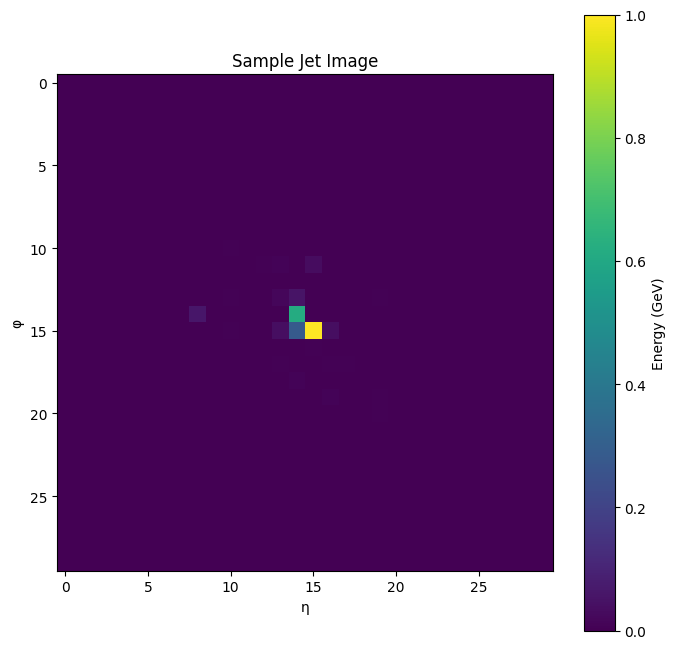

In [3]:

# Visualize a sample jet image
plot_jet_image(X_train[3400, :, :], "Sample Jet Image")#

## 2. Build CNN Model

We'll create a CNN with:
- Convolutional layers to learn spatial patterns
- MaxPooling layers to reduce spatial dimensions
- Dense layers for classification
- Dropout for regularization

In [4]:
def build_cnn_model(input_shape):
    model = keras.Sequential([
        # First convolutional block
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.MaxPooling2D((2, 2)),

        # Second convolutional block
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Third convolutional block
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        
        # Flatten and dense layers
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),   
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dropout(0.1), 
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dropout(0.01), 
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    return model

# Create and compile model
model = build_cnn_model(X_train.shape[1:])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-24 16:32:45.201775: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,097 (484.75 KB)

 Trainable params: 124,097 (484.75 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
X_train.shape

(3520, 30, 30, 1)

## 3. Train Model

We'll train the CNN with:
- Early stopping to prevent overfitting
- Validation split to monitor performance
- Batch size of 32 for stable training

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.6462 - loss: 0.5894 - val_accuracy: 0.9091 - val_loss: 0.3687
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8876 - loss: 0.3773 - val_accuracy: 0.9048 - val_loss: 0.3447
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8934 - loss: 0.3526 - val_accuracy: 0.9077 - val_loss: 0.3106
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8891 - loss: 0.3406 - val_accuracy: 0.9006 - val_loss: 0.2849
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9048 - loss: 0.2822 - val_accuracy: 0.9048 - val_loss: 0.2668
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9030 - loss: 0.2730 - val_accuracy: 0.9034 - val_loss: 0.2722
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8998 - loss: 0.2621 - val_accuracy: 0.9091 - val_loss: 0.2545
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9029 - loss: 0.2646 - val_accuracy: 0.9105 - v

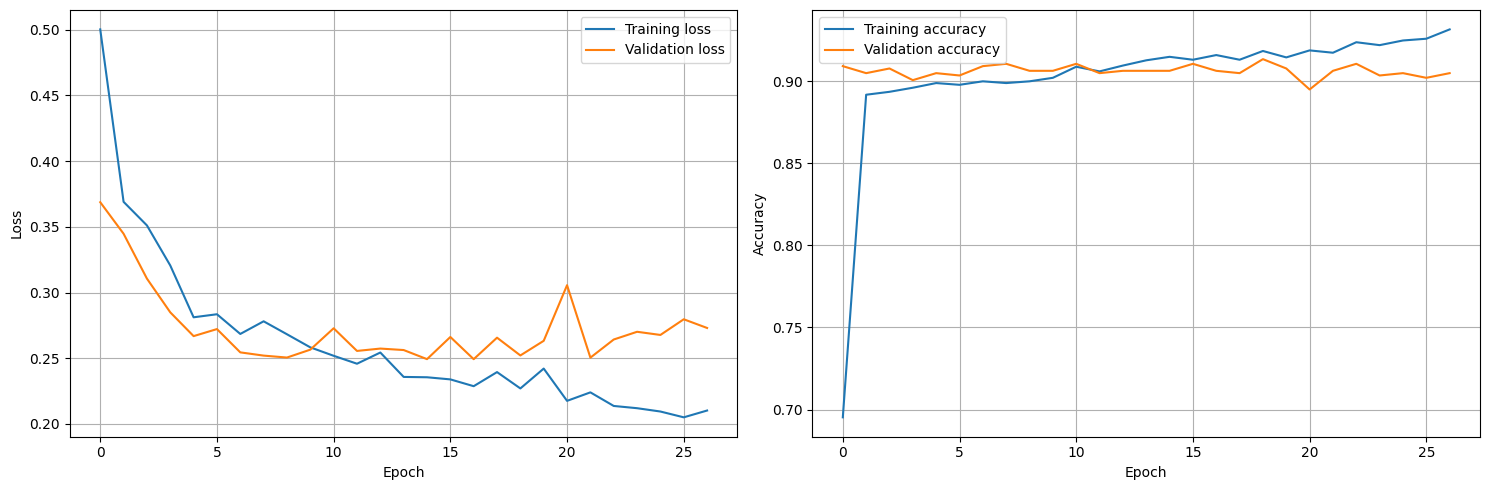

In [6]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)

# Plot training history
plot_training_history(history)

## 4. Evaluate Model

Let's evaluate our model's performance on the test set.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9116 - loss: 0.2734
Test Accuracy: 0.8944
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


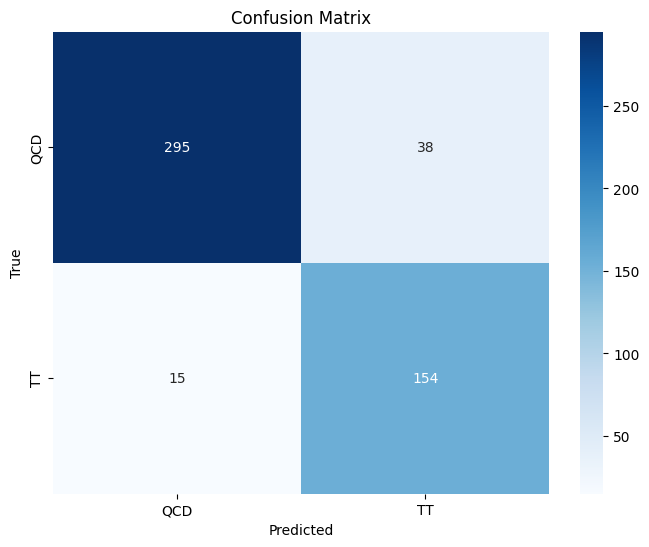

In [7]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_val_, y_val)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred = model.predict(X_val_)
y_pred_discrete = (y_pred > 0.5).astype(int)
# Plot confusion matrix
plot_confusion_matrix(y_val, y_pred_discrete)

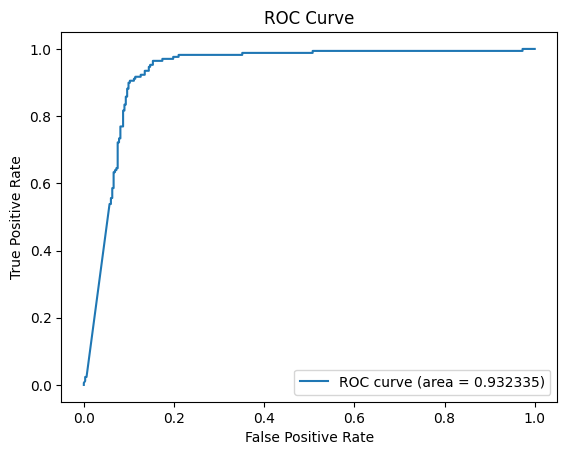

In [8]:
plot_roc_curve(y_val, y_pred)

# 5 - Making predictions

In [9]:
import pandas as pd 
test_predictions = model.predict(X_test)
print(test_ids.shape)
print(test_predictions.shape)
solution = pd.DataFrame({'id':test_ids, 'label':test_predictions.reshape(-1)})
solution.to_csv('submission.csv', index=False)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1005,)
(1005, 1)
